## NIH Chest X-Ray Disease Classification

### Data Wrangling Code from Previous Notebook
---

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# Data Wrangling
df = pd.read_csv('/Users/tungnguyen/Documents/capstone/Data_Entry_2017.csv')
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x','y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Fix patient age typos
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Binarize
mlb = MultiLabelBinarizer()
temp = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(temp, columns=mlb.classes_)
      
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 23)


### Iterative Train / Test Split using scikit-multilearn
---

In [3]:
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

In [4]:
X = df[['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']]
y = df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 
        'Mass', 'No Finding', 'Nodule','Pleural_Thickening', 'Pneumonia', 'Pneumothorax']]

X_train, y_train, X_test, y_test = iterative_train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

In [5]:
# Verify shapes of train / test matrices
print('X_train shape = {}'.format(X_train.shape))
print('X_test shape = {}'.format(X_test.shape))
print('y_train shape = {}'.format(y_train.shape))
print('y_test shape = {}'.format(y_test.shape))

X_train shape = (84207, 6)
X_test shape = (27910, 6)
y_train shape = (84207, 15)
y_test shape = (27910, 15)


#### Train vs. Test Distribution

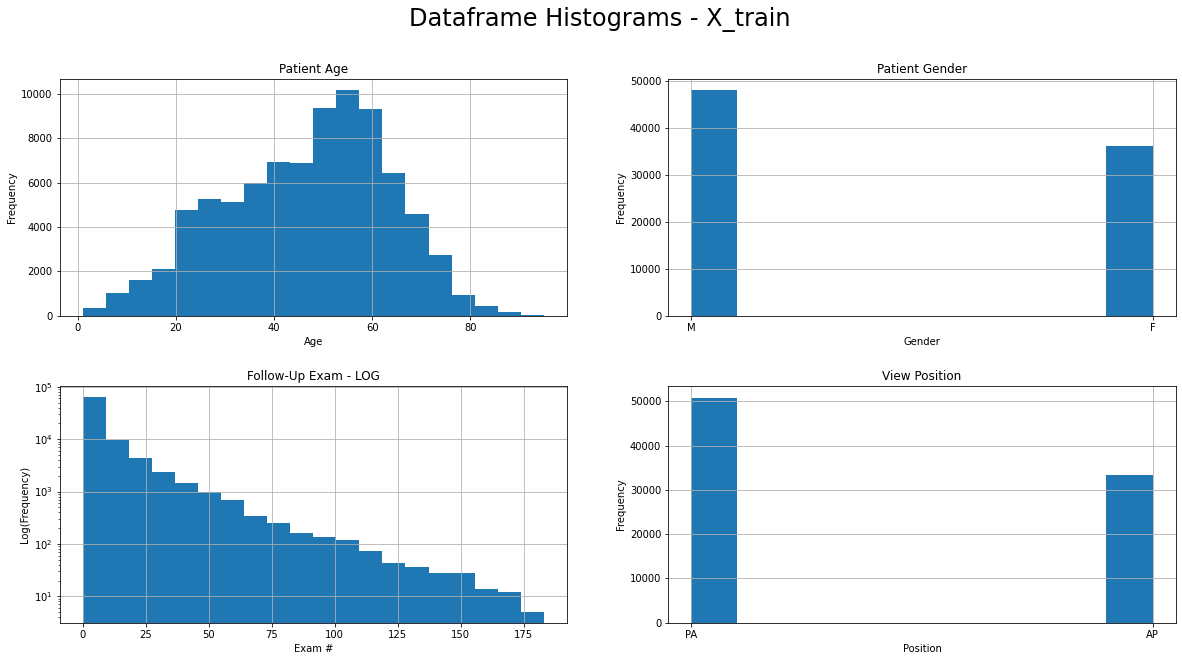

In [6]:
df_plt = pd.DataFrame(X_train, columns=['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position'])
                  
fig, axes = plt.subplots(2, 2, figsize=[20, 10])

fig.subplots_adjust(hspace=0.3)

fig.suptitle('Dataframe Histograms - X_train', fontsize=24)

df_plt['Patient Age'].hist(ax=axes[0, 0], bins=20)
axes[0, 0].title.set_text('Patient Age');
axes[0, 0].set_xlabel('Age');
axes[0, 0].set_ylabel('Frequency');

df_plt['Patient Gender'].hist(ax=axes[0, 1])
axes[0, 1].title.set_text('Patient Gender');
axes[0, 1].set_xlabel('Gender');
axes[0, 1].set_ylabel('Frequency');

df_plt['Follow-up #'].hist(ax=axes[1, 0], log=True, bins=20)
axes[1, 0].title.set_text('Follow-Up Exam - LOG');
axes[1, 0].set_xlabel('Exam #');
axes[1, 0].set_ylabel('Log(Frequency)');

df_plt['View Position'].hist(ax=axes[1, 1])
axes[1, 1].title.set_text('View Position');
axes[1, 1].set_xlabel('Position');
axes[1, 1].set_ylabel('Frequency');

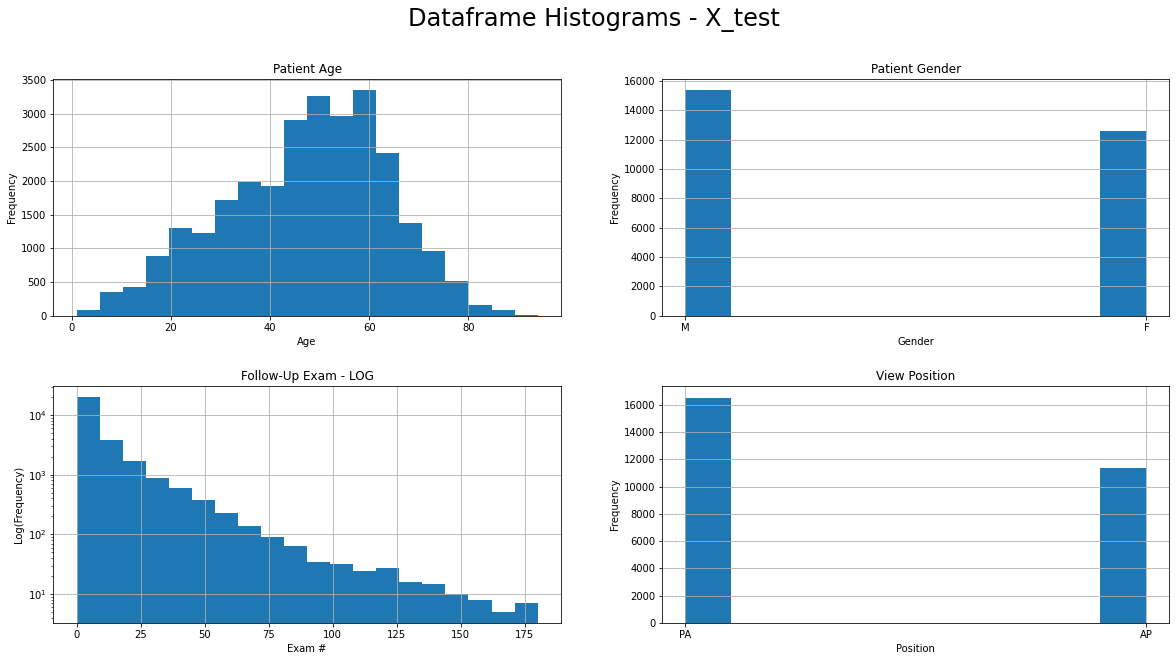

In [7]:
df_plt = pd.DataFrame(X_test, columns=['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position'])
                  
fig, axes = plt.subplots(2, 2, figsize=[20, 10])

fig.subplots_adjust(hspace=0.3)

fig.suptitle('Dataframe Histograms - X_test', fontsize=24)

df_plt['Patient Age'].hist(ax=axes[0, 0], bins=20)
axes[0, 0].title.set_text('Patient Age');
axes[0, 0].set_xlabel('Age');
axes[0, 0].set_ylabel('Frequency');

df_plt['Patient Gender'].hist(ax=axes[0, 1])
axes[0, 1].title.set_text('Patient Gender');
axes[0, 1].set_xlabel('Gender');
axes[0, 1].set_ylabel('Frequency');

df_plt['Follow-up #'].hist(ax=axes[1, 0], log=True, bins=20)
axes[1, 0].title.set_text('Follow-Up Exam - LOG');
axes[1, 0].set_xlabel('Exam #');
axes[1, 0].set_ylabel('Log(Frequency)');

df_plt['View Position'].hist(ax=axes[1, 1])
axes[1, 1].title.set_text('View Position');
axes[1, 1].set_xlabel('Position');
axes[1, 1].set_ylabel('Frequency');

### Simple Convolutional Neural Network (CNN)
---

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_df = pd.DataFrame(np.hstack((X_train[:,0].reshape(-1, 1), y_train)),
                        columns=['file', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 
                                 'Mass', 'No Finding', 'Nodule','Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

test_df = pd.DataFrame(np.hstack((X_test[:,0].reshape(-1, 1), y_test)),
                       columns=['file', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 
                                'Mass', 'No Finding', 'Nodule','Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

for col in train_df:
    if col != 'file':
        train_df[col] = train_df[col].astype(np.int)
        
for col in train_df:
    if col != 'file':
        test_df[col] = test_df[col].astype(np.int)

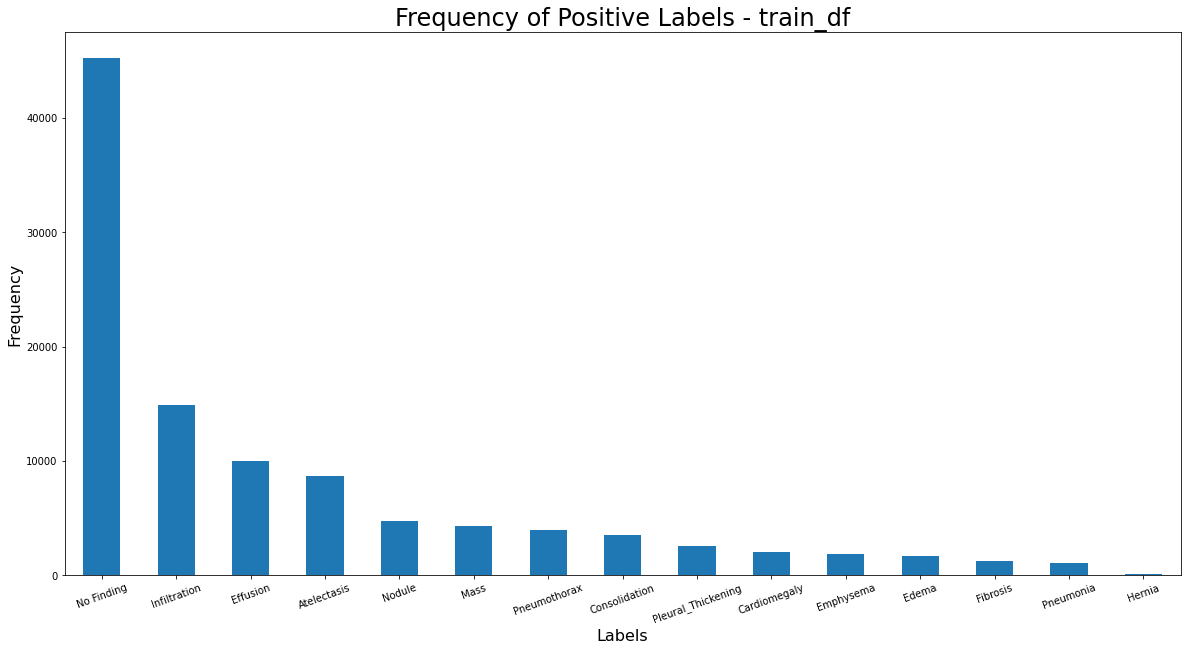

In [47]:
df_agg = train_df.drop('file', axis=1).sum().sort_values(ascending=False)

fig = df_agg.plot(kind='bar', figsize=(20, 10), rot=20);
fig.set_title('Frequency of Positive Labels - train_df', fontsize=24);
fig.set_xlabel('Labels', fontsize=16);
fig.set_ylabel('Frequency', fontsize=16);

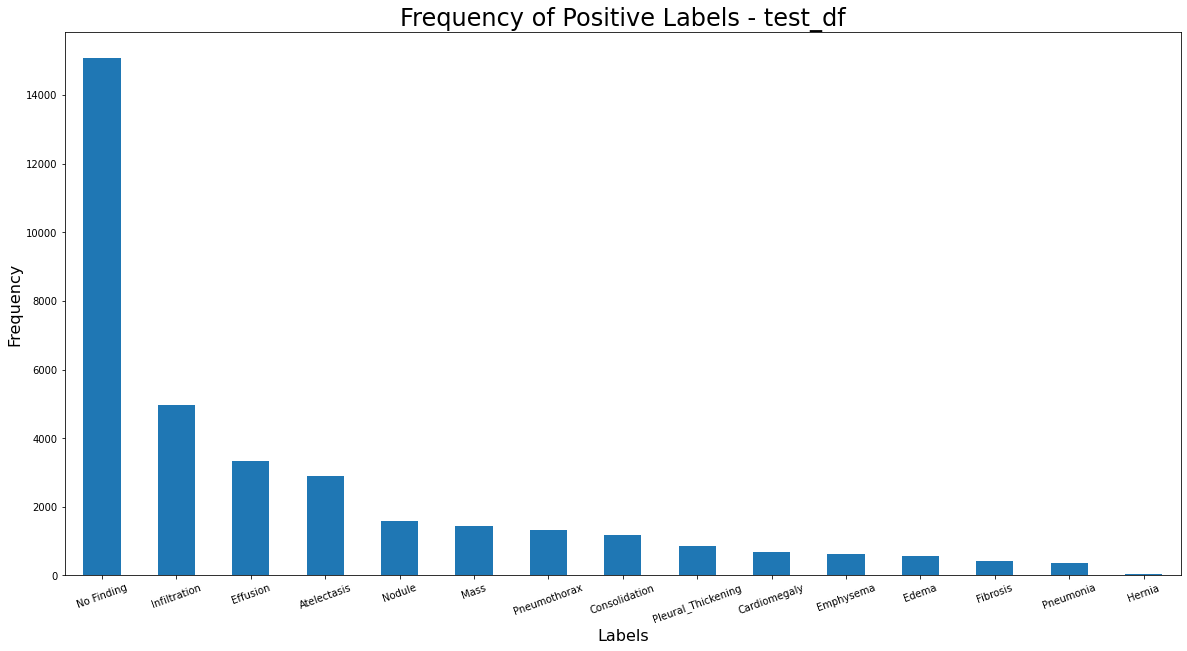

In [46]:
df_agg = test_df.drop('file', axis=1).sum().sort_values(ascending=False)

fig = df_agg.plot(kind='bar', figsize=(20, 10), rot=20);
fig.set_title('Frequency of Positive Labels - test_df', fontsize=24);
fig.set_xlabel('Labels', fontsize=16);
fig.set_ylabel('Frequency', fontsize=16);

In [10]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, target_size=(256, 256), val_split=0.2, batch_size=50, color_mode='rgb'):

    datagen = ImageDataGenerator(validation_split=val_split)

    train_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='training')

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation')

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols)
    
    return train_generator, validation_generator, test_generator

In [11]:
data_path = '/Users/tungnguyen/Documents/capstone/data/'
x_col = 'file'
y_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 
          'Mass', 'No Finding', 'Nodule','Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

train_gen, val_gen, test_gen = datagen_from_df(train_df, test_df, x_col, y_cols, data_path, 
                                               target_size=(256, 256), val_split=0.2, batch_size=50, color_mode='grayscale')

Found 67366 validated image filenames.
Found 16841 validated image filenames.
Found 27910 validated image filenames.


In [12]:
model = Sequential([
    Conv2D(15, kernel_size=10, activation='relu', padding='same', input_shape=(256, 256, 1)),
    Conv2D(15, kernel_size=10, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(15, activation='softmax')
])

Metal device set to: Apple M1 Max


2021-12-21 00:25:59.106050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-21 00:25:59.106203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 15)      1515      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 15)      22515     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 15)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 245760)            0         
                                                                 
 dense (Dense)               (None, 15)                3686415   
                                                                 
Total params: 3,710,445
Trainable params: 3,710,445
Non-trainable params: 0
______________________________________________

In [14]:
model_file = '/Users/tungnguyen/Documents/repos/mec-capstone/simple_cnn.h5'
check = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, 
                        save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

callbacks = [check, early]

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
%%time
model.fit(train_gen, 
          validation_data=val_gen, 
          epochs=25, 
          callbacks=callbacks)

2021-12-21 00:25:59.773023: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-21 00:25:59.897732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/25
1348/1348 [==============================] - ETA: 0s - loss: 1.2102 - accuracy: 0.5180

2021-12-21 00:39:13.898615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.22760, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/simple_cnn.h5
1348/1348 [==============================] - 994s 737ms/step - loss: 1.2102 - accuracy: 0.5180 - val_loss: 0.2276 - val_accuracy: 0.5769
Epoch 2/25
1348/1348 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.5240
Epoch 00002: val_loss improved from 0.22760 to 0.21618, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/simple_cnn.h5
1348/1348 [==============================] - 989s 733ms/step - loss: 0.2206 - accuracy: 0.5240 - val_loss: 0.2162 - val_accuracy: 0.5706
Epoch 3/25
1348/1348 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.5294
Epoch 00003: val_loss improved from 0.21618 to 0.20908, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/simple_cnn.h5
1348/1348 [==============================] - 989s 734ms/step - loss: 0.2120 - accuracy: 0.5294 - val_loss: 0.2091 - val_accuracy: 0.57

In [17]:
def plot_losses(model):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.plot(model.history.history['val_loss'], 'r-o')
    ax.plot(model.history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss', fontsize=18, fontweight='bold')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

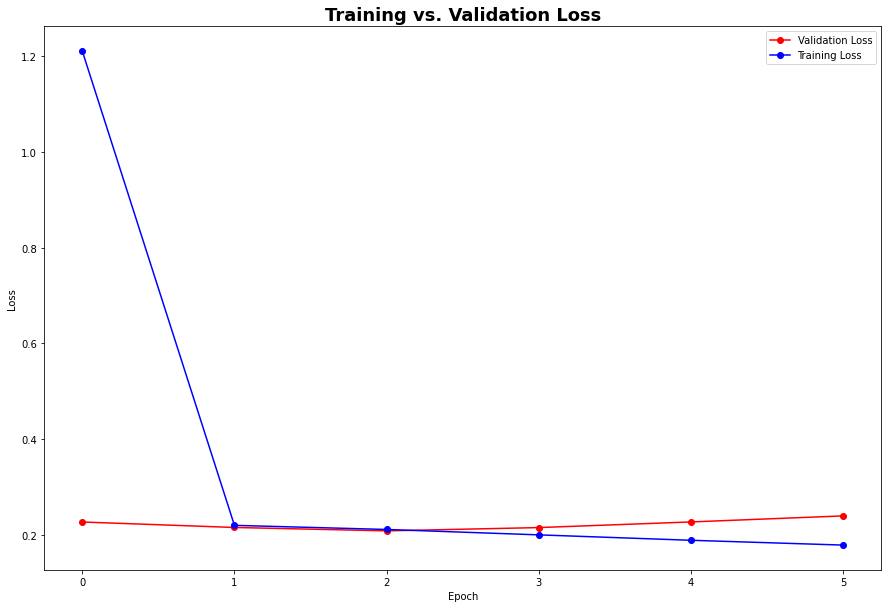

In [18]:
plot_losses(model)

In [19]:
from sklearn.metrics import roc_curve, auc

def postprocess(model, test_gen, model_name, batch_size=50):
    y_pred = model.predict(test_gen, batch_size=batch_size, verbose=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    for i, lbl in enumerate(y_cols):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (lbl, auc(fpr, tpr)))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name, fontsize=18, fontweight='bold');
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

2021-12-21 02:04:53.100100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


559/559 [==============================] - 322s 576ms/step


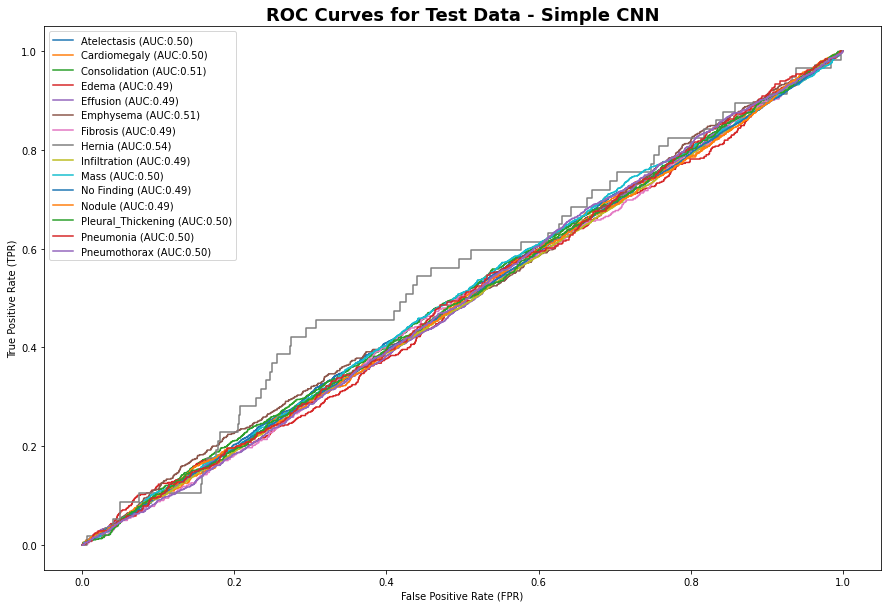

In [20]:
postprocess(model, test_gen, model_name='Simple CNN', batch_size=100)

### Pretrained Model - VGG16 - ImageNet Weights
---

In [21]:
from tensorflow.keras.applications.vgg16 import VGG16

In [22]:
vgg = VGG16(weights='imagenet')

model = Sequential()

for layer in vgg.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False
    
model.layers.pop()
model.add(Dense(15, activation='softmax'))

In [23]:
model.layers[0].input_shape

(None, 224, 224, 3)

In [24]:
train_gen, val_gen, test_gen = datagen_from_df(train_df, test_df, x_col, y_cols, data_path, 
                                               target_size=(224, 224), val_split=0.2, batch_size=50, color_mode='rgb')

Found 67366 validated image filenames.
Found 16841 validated image filenames.
Found 27910 validated image filenames.


In [25]:
model_file = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16_imgnet_cnn.h5'
check_vgg = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min', save_weights_only = True)
callbacks_vgg = [check_vgg, early]

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
%%time
model.fit(train_gen, 
          validation_data=val_gen, 
          epochs=25, 
          callbacks=callbacks_vgg)

Epoch 1/25


2021-12-21 02:10:18.716596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1348/1348 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.5219

2021-12-21 02:24:08.080057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.26239, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16_imgnet_cnn.h5
1348/1348 [==============================] - 1041s 772ms/step - loss: 0.4076 - accuracy: 0.5219 - val_loss: 0.2624 - val_accuracy: 0.5797
Epoch 2/25
1348/1348 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.5271
Epoch 00002: val_loss improved from 0.26239 to 0.21254, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16_imgnet_cnn.h5
1348/1348 [==============================] - 1039s 770ms/step - loss: 0.2446 - accuracy: 0.5271 - val_loss: 0.2125 - val_accuracy: 0.5797
Epoch 3/25
1348/1348 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.5270
Epoch 00003: val_loss improved from 0.21254 to 0.20292, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16_imgnet_cnn.h5
1348/1348 [==============================] - 1041s 772ms/step - loss: 0.2225 - accuracy: 0.5270 - val_loss: 0.2029

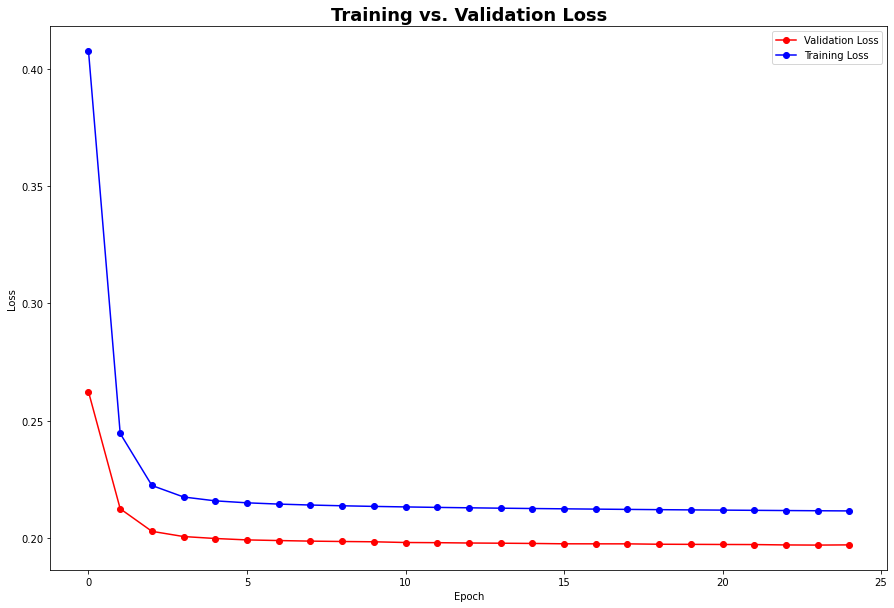

In [28]:
plot_losses(model)

2021-12-21 09:24:00.291607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


559/559 [==============================] - 346s 619ms/step


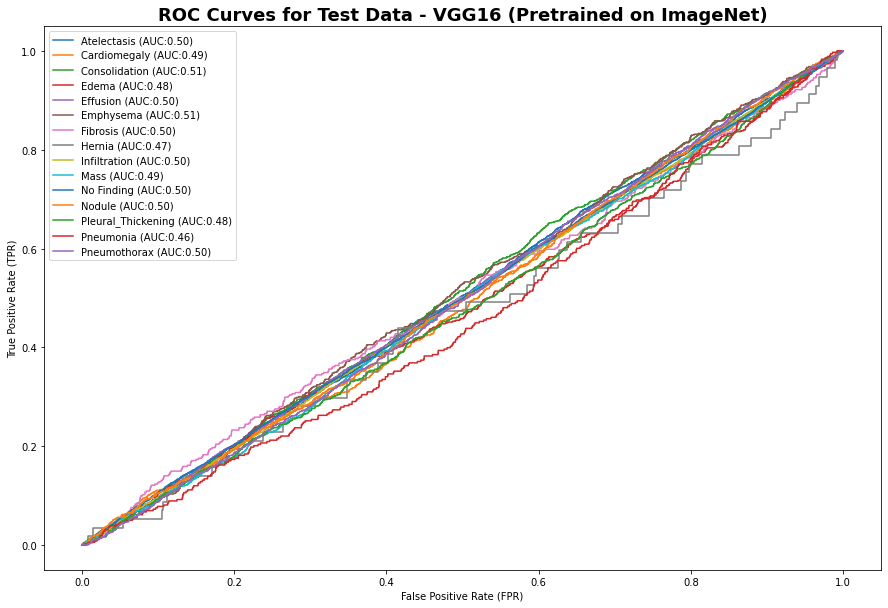

In [29]:
postprocess(model, test_gen, model_name='VGG16 (Pretrained on ImageNet)', batch_size=100)

### Deep CNN
---

In [ ]:
train_gen, val_gen, test_gen = datagen_from_df(train_df, test_df, x_col, y_cols, data_path, 
                                               target_size=(1024, 1024), val_split=0.2, batch_size=50, color_mode='grayscale')

In [ ]:
model_file = '/Users/tungnguyen/Documents/repos/mec-capstone/deep_cnn.h5'
check_multi = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, 
                              save_best_only=True, mode='min', save_weights_only = True)
callbacks_multi = [check_multi, early]

In [ ]:
model = Sequential([
    Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(1024, 1024, 1)),
    Conv2D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(512, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(1024, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(15, activation='softmax')
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
model.fit(train_gen, 
          validation_data=val_gen, 
          epochs=25, 
          callbacks=callbacks_multi)

In [ ]:
plot_losses(model)

In [ ]:
postprocess(model, test_gen, model_name='Deep CNN', batch_size=100)

### VGG16 - Train From Scratch
---

In [30]:
from tensorflow.keras.layers import Input

In [31]:
train_gen, val_gen, test_gen = datagen_from_df(train_df, test_df, x_col, y_cols, data_path, 
                                               target_size=(256, 256), val_split=0.2, batch_size=50, color_mode='rgb')

Found 67366 validated image filenames.
Found 16841 validated image filenames.
Found 27910 validated image filenames.


In [32]:
vgg16 = VGG16(include_top=False, input_shape=(256, 256, 3))

In [33]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)
    
model.layers.pop()
model.add(Dense(15, activation='softmax'))

In [ ]:
model.summary()

In [35]:
model_file = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16_cnn.h5'
check_vgg16 = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, 
                              save_best_only=True, mode='min', save_weights_only = True)
callbacks_vgg16 = [check_vgg16, early]

In [36]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
model.fit(train_gen, 
          validation_data=val_gen, 
          epochs=25, 
          callbacks=callbacks_vgg16)

In [ ]:
plot_losses(model)

In [ ]:
postprocess(model, test_gen, model_name='VGG16 (No Weights Initialization)', batch_size=100)